# Anomaly Detection Toolkit Tutorial #
This notebook is based on the tutorial at: https://youtu.be/T5wB7pk3CUc?si=26dLnaJX7H2dRvCy  <br>
It teaches us to detect anomalies in time series data using the Anomaly Detection Toolkit (ADTK).<br>
<br>
Github for the tutorial is: https://github.com/marcopeix/youtube_tutorials/blob/main/YT_02_anomaly_detection_time_series.ipynb <br>
<br>
Source for the data is: https://datahub.io/core/global-temp <br>
<br>
<br>
The Dataset repository used for this tutorial has 145 data repositories (at the time of taking the tutorial, 11/11/2024).  It is labeled as Curated open data.  

In [67]:
import pandas as pd 
import matplotlib.pyplot as plt 
import yfinance as yf 
import seaborn as sns
import numpy as np 

# Set a global style before using adtk
sns.set_style("whitegrid")  # Or use any other available style
plt.style.use('seaborn-v0_8-whitegrid')

from adtk.data import validate_series
# from adtk.visualization import plot # Visualization is broken because of a hardcoded seaborn style that no longer exists.
from adtk.detector import *

In [68]:
df = pd.read_csv("data/monthly.csv")
df['Date'] = df['Year']
df = df.drop(columns=['Year'])
df['Date'] = pd.to_datetime(df['Date'])
df.head()


,Source,Mean,Date
0,gcag,-0.6746,1850-01-01
1,gcag,-0.3334,1850-02-01
2,gcag,-0.5913,1850-03-01
3,gcag,-0.5887,1850-04-01
4,gcag,-0.5088,1850-05-01


In [69]:
df = df.set_index('Date')
df = df['Mean']
df.head()

Date
1850-01-01   -0.6746
1850-02-01   -0.3334
1850-03-01   -0.5913
1850-04-01   -0.5887
1850-05-01   -0.5088
Name: Mean, dtype: float64

#### A "Dumb" threshold detector for anomalies. ####
It uses static values for bottom and top thresholds.

In [70]:
threshold_detector = ThresholdAD(low=-0.5, high=0.75)
anomalies = threshold_detector.detect(df)
anomalies

Date
1850-01-01     True
1850-02-01    False
1850-03-01     True
1850-04-01     True
1850-05-01     True
              ...  
2024-03-01     True
2024-04-01     True
2024-05-01     True
2024-06-01     True
2024-07-01     True
Name: Mean, Length: 3823, dtype: bool

In [71]:
# We had to write a quick visualizer because the adtk vizualizations package is broken.
def plot_anomalies(data, anomalies, color='red', title="Data with Anomalies", figsize=(12, 6)):
    """
    Plot normal data and anomalies using Matplotlib.

    Parameters:
    - data: Pandas Series, the time series data to plot
    - anomalies: Pandas Series or list, the same length as data, 
                 with True/False indicating anomaly points
    - title: str, title of the plot
    - figsize: tuple, size of the figure
    """
    # if not isinstance(data, pd.Series):
    #     raise ValueError("Data must be a Pandas Series")
    if not isinstance(anomalies, (pd.Series, list, np.ndarray)):
        raise ValueError("Anomalies must be a Pandas Series, list, or NumPy array")
    if len(data) != len(anomalies):
        raise ValueError("Data and anomalies must have the same length")
    
    # Plotting
    plt.figure(figsize=figsize)
    plt.plot(data.index, data.values, label='Normal Data', color='blue',linewidth=0.8)
    
    # Highlight anomalies
    anomalies = pd.Series(anomalies, index=data.index)
    plt.scatter(data.index[anomalies], data[anomalies], 
                color=color, label='Anomalies', s=5, zorder=3)

    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    plt.legend()
    plt.show()

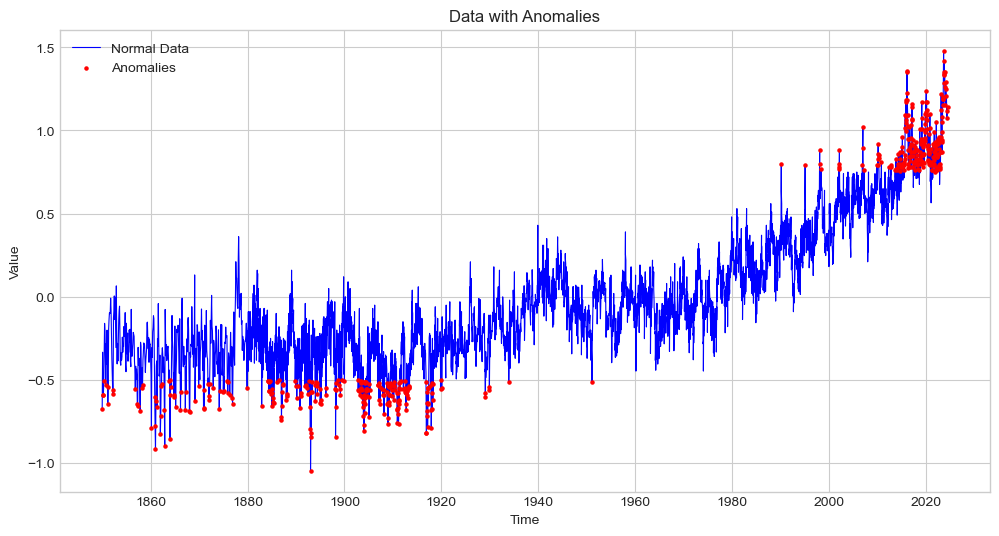

In [72]:
# Plot using the custom function
plot_anomalies(df, anomalies)

#### We can make our dumb threshold a little better by making it a QuantileAD instead ####
We will go for a 99th percentile and 1st percentile.

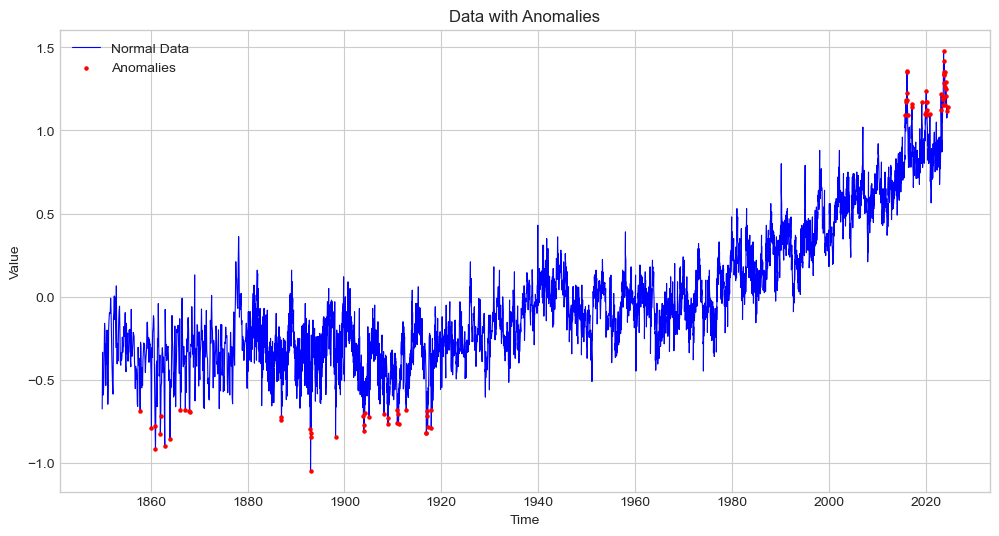

In [73]:
quantile_detector = QuantileAD(low=0.01, high=0.99)
qd_anomalies = quantile_detector.fit_detect(df)

# Plot using the custom function
plot_anomalies(df, qd_anomalies)

#### Another threshold detector, which is an Interquartile Range (IQR) ####
The Interquartile Range (IQR) is a measure of statistical dispersion, representing the spread of the middle 50% of a dataset. It is calculated as the difference between the third quartile (Q3) and the first quartile (Q1):
$$
\mathrm{IQR} = Q_3 - Q_1
$$
<br>
In machine learning and data analysis, the IQR is often used in data preprocessing to detect and remove outliers, which can skew the results of models, especially those sensitive to extreme values (e.g., linear regression).<br>


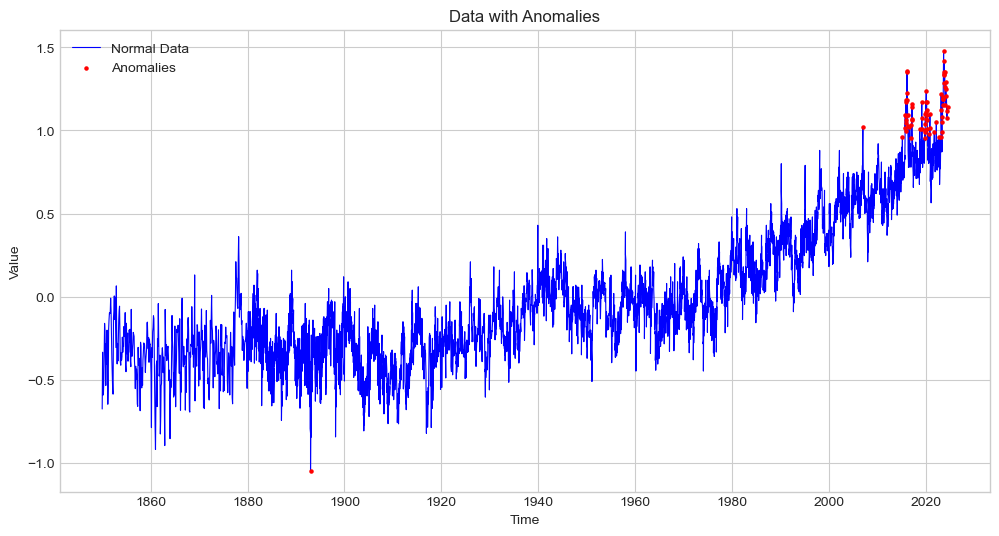

In [74]:
iqr_detector = InterQuartileRangeAD(c=1.5)
iqr_anomalies = iqr_detector.fit_detect(df)

# Plot using the custom function
plot_anomalies(df, iqr_anomalies)

#### Another method uses the Generalized Extreme Studentized Deviate (ESD) Test ####

The Generalized Extreme Studentized Deviate (ESD) Test is a statistical method used to detect multiple outliers in a dataset. Unlike simpler methods like the Z-score or the IQR rule, which may be less effective when dealing with more than one outlier, the generalized ESD test is designed to identify several outliers simultaneously.<br>
<br>
The Generalized ESD Test is commonly used in anomaly detection in time series data, quality control, and various scientific fields where detecting multiple outliers is crucial.<br>
<br>
`This data is not a normal distribution, so this method is not really valid, which we see with no anomalies`<br>
<br>
##### Example Use Case: #####
  - Detecting unusual patterns in financial time series, such as identifying fraudulent transactions.
  - Monitoring sensor data in predictive maintenance to find anomalies that may indicate malfunctioning equipment.

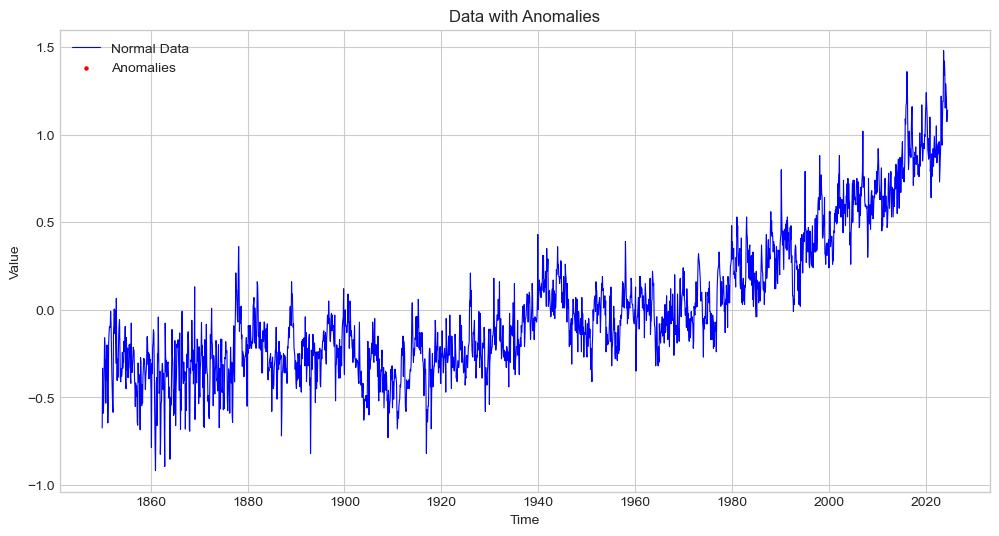

In [75]:
df = validate_series(df)
esd_detector = GeneralizedESDTestAD(alpha=0.3)
esd_anomalies = esd_detector.fit_detect(df)

# Plot using the custom function
plot_anomalies(df, esd_anomalies)

## Switching Datasets to Yahoo Finance ##

In [76]:
df = yf.download("BBAI")['Close']
# df['Date'] = pd.to_datetime(df['Date'])
# df = df.set_index('Date')
print(df.index)
print(df)
df.head()

[*********************100%***********************]  1 of 1 completed

DatetimeIndex(['2021-04-05 00:00:00+00:00', '2021-04-06 00:00:00+00:00',
               '2021-04-07 00:00:00+00:00', '2021-04-08 00:00:00+00:00',
               '2021-04-09 00:00:00+00:00', '2021-04-12 00:00:00+00:00',
               '2021-04-13 00:00:00+00:00', '2021-04-14 00:00:00+00:00',
               '2021-04-15 00:00:00+00:00', '2021-04-16 00:00:00+00:00',
               ...
               '2024-10-29 00:00:00+00:00', '2024-10-30 00:00:00+00:00',
               '2024-10-31 00:00:00+00:00', '2024-11-01 00:00:00+00:00',
               '2024-11-04 00:00:00+00:00', '2024-11-05 00:00:00+00:00',
               '2024-11-06 00:00:00+00:00', '2024-11-07 00:00:00+00:00',
               '2024-11-08 00:00:00+00:00', '2024-11-11 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Date', length=909, freq=None)
Ticker                     BBAI
Date                           
2021-04-05 00:00:00+00:00  9.83
2021-04-06 00:00:00+00:00  9.71
2021-04-07 00:00:00+00:00  9.62
2021-04-08 

Ticker,BBAI
Date,
2021-04-05 00:00:00+00:00,9.83
2021-04-06 00:00:00+00:00,9.71
2021-04-07 00:00:00+00:00,9.62
2021-04-08 00:00:00+00:00,9.62
2021-04-09 00:00:00+00:00,9.62


c:\Users\JoeDavis\anaconda3\Lib\site-packages\adtk\detector\_detector_1d.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  predicted[s.isna()] = np.nan
c:\Users\JoeDavis\anaconda3\Lib\site-packages\adtk\detector\_detector_1d.py:141: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  predicted[s.isna()] = np.nan
c:\Users\JoeDavis\anaconda3\Lib\site-packages\adtk\aggregator\_aggregator.py:211: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  predicted[predicted & lists.isna().any(axis=1)] = float("nan")
c:

Date
2021-04-05 00:00:00+00:00    False
2021-04-06 00:00:00+00:00    False
2021-04-07 00:00:00+00:00    False
2021-04-08 00:00:00+00:00    False
2021-04-09 00:00:00+00:00    False
                             ...  
2024-11-05 00:00:00+00:00    False
2024-11-06 00:00:00+00:00    False
2024-11-07 00:00:00+00:00    False
2024-11-08 00:00:00+00:00    False
2024-11-11 00:00:00+00:00    False
Name: BBAI, Length: 909, dtype: bool


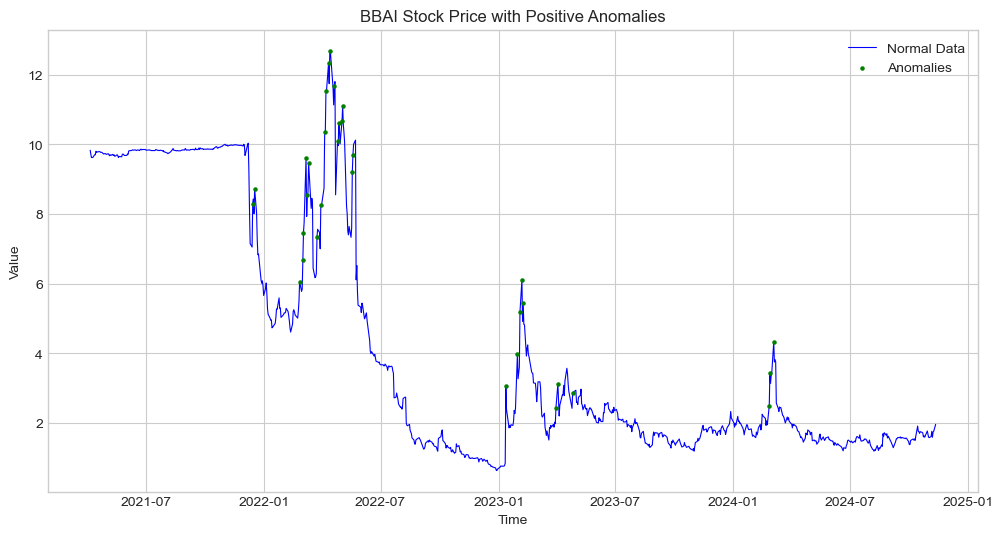

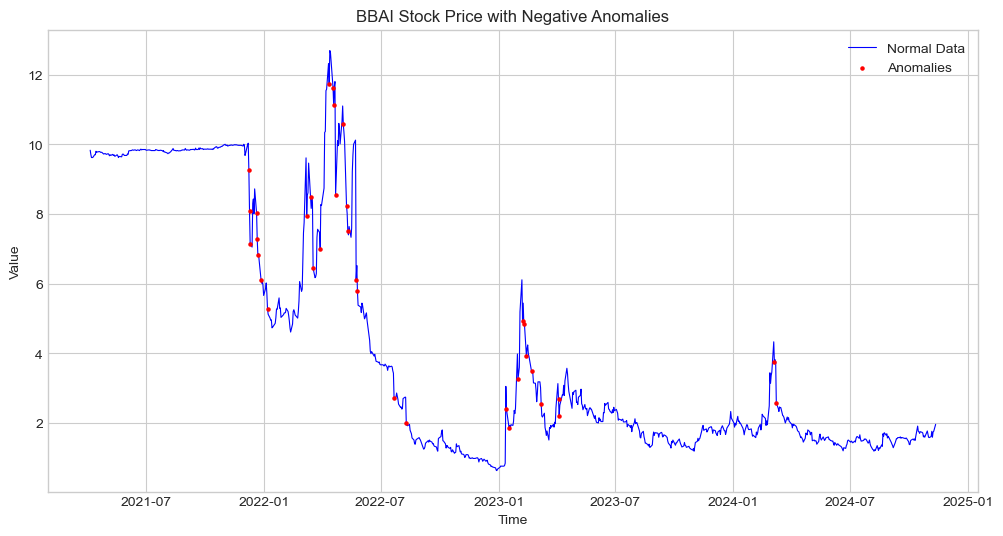

In [78]:
df = validate_series(df)

persist_detector_pos = PersistAD(c=3.0, side="positive")
p_anomalies = persist_detector_pos.fit_detect(df['BBAI'])
p_anomalies = p_anomalies.fillna(False)

persist_detector_neg = PersistAD(c=3.0, side="negative")
n_anomalies = persist_detector_neg.fit_detect(df['BBAI'])
n_anomalies = n_anomalies.fillna(False)

print(p_anomalies)
plot_anomalies(df, p_anomalies, 'green', title="BBAI Stock Price with Positive Anomalies")
plot_anomalies(df, n_anomalies, 'red', title="BBAI Stock Price with Negative Anomalies")

c:\Users\JoeDavis\anaconda3\Lib\site-packages\adtk\detector\_detector_1d.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  predicted[s.isna()] = np.nan
c:\Users\JoeDavis\anaconda3\Lib\site-packages\adtk\detector\_detector_1d.py:141: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  predicted[s.isna()] = np.nan
c:\Users\JoeDavis\anaconda3\Lib\site-packages\adtk\aggregator\_aggregator.py:211: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  predicted[predicted & lists.isna().any(axis=1)] = float("nan")
c:

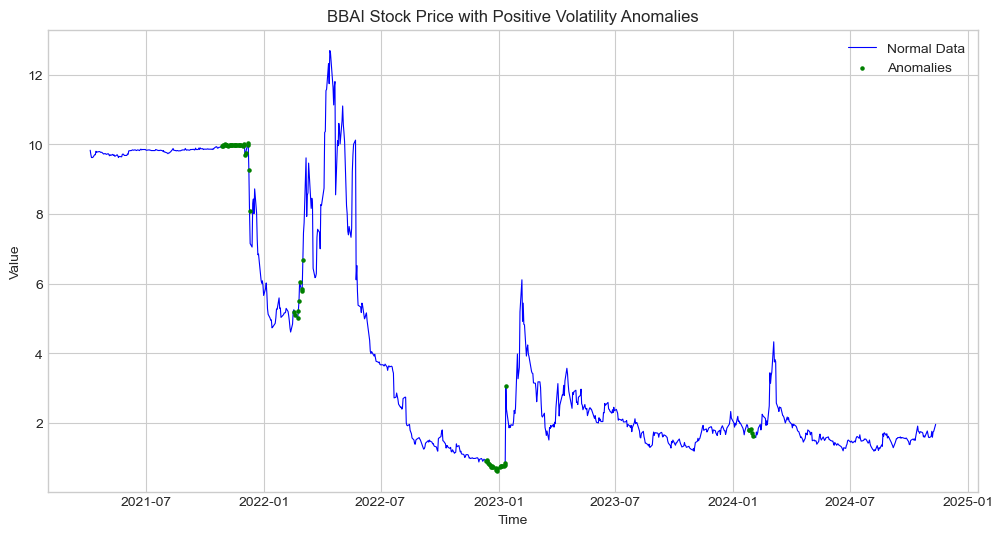

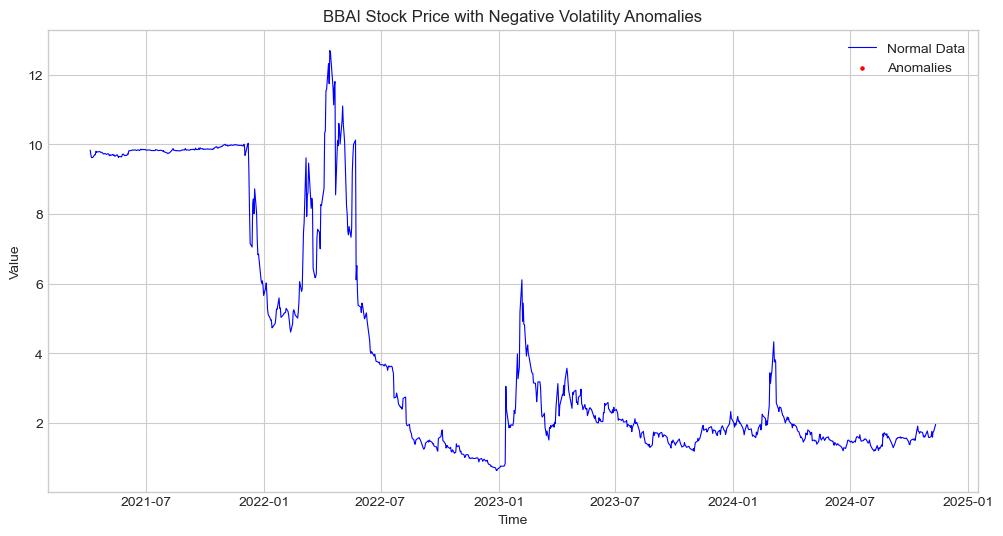

In [85]:
volatility_detector = VolatilityShiftAD(c=6.0, side="positive", window=30)
vp_anomalies = volatility_detector.fit_detect(df)
vp_anomalies = vp_anomalies.fillna(False)

volatility_detector = VolatilityShiftAD(c=6.0, side="negative", window=30)
vn_anomalies = volatility_detector.fit_detect(df)
vn_anomalies = vn_anomalies.fillna(False)


plot_anomalies(df, vp_anomalies['BBAI'], 'green', title="BBAI Stock Price with Positive Volatility Anomalies")
plot_anomalies(df, vn_anomalies['BBAI'], 'red', title="BBAI Stock Price with Negative Volatility Anomalies")